In [4]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import torch

from util import load_harps_spectrum
from whitening import apply_rad_vel, velocity_transform

In [5]:
from harps_spec_info import harps_spec_info as spec_info
WAVE = spec_info.WAVE

In [3]:
harps_IDs = pd.read_csv('lists/HARPS-IDs.txt',header=None,names=['ID'])
harps_IDs

,ID
0,ADP.2014-09-16T11:03:30.940
1,ADP.2014-09-16T11:03:30.947
2,ADP.2014-09-16T11:03:30.973
3,ADP.2014-09-16T11:03:31.000
4,ADP.2014-09-16T11:03:31.007
...,...
267356,ADP.2019-04-19T01:13:31.386
267357,ADP.2019-04-19T01:13:31.388
267358,ADP.2019-04-19T01:13:31.390
267359,ADP.2019-04-19T01:13:31.392


In [11]:
# Load berv parameters
bervs = pd.read_csv('./public_harps_idps_berv.csv')

### Whitening

In [5]:
ids_to_test = harps_IDs.ID.values[range(1000,10000,100)] # The randomly selected spectra used in the publication

data_topo = []
data_randvel = []
for i,spec_ID in enumerate(ids_to_test):

    #-- Load the original spectrum
    w, data = load_harps_spectrum(specID=spec_ID,data_path='~/remote_epyc_data3/HARPS/fits/')
    
    #-- Apply the pre-processing steps (trimming, uniform wavelength grids) 
    _, flux = spec_info.preprocess(w, data)
    
    #-- Transform to the topo-centric frame
    berv = bervs[bervs['dp_id']==spec_ID]['kw_value'].values[0]
    w_topo, f_topo = apply_rad_vel(WAVE, flux, berv)
    data_topo.append(f_topo)
    
    #-- Emulate a random radial velocity, to increase the mutual entropy across various spectra
    max_vel = 30 # km/s
    randvel = np.random.uniform(-max_vel, max_vel)
    w_randvel, f_randvel = apply_rad_vel(w_topo, f_topo, randvel)
    data_randvel.append(f_randvel)
    
data_topo = np.array(data_topo)
data_randvel = np.array(data_randvel)

Visualize a sample spectrum (the last one in the loop) in the three reference frames

<IPython.core.display.Javascript object>


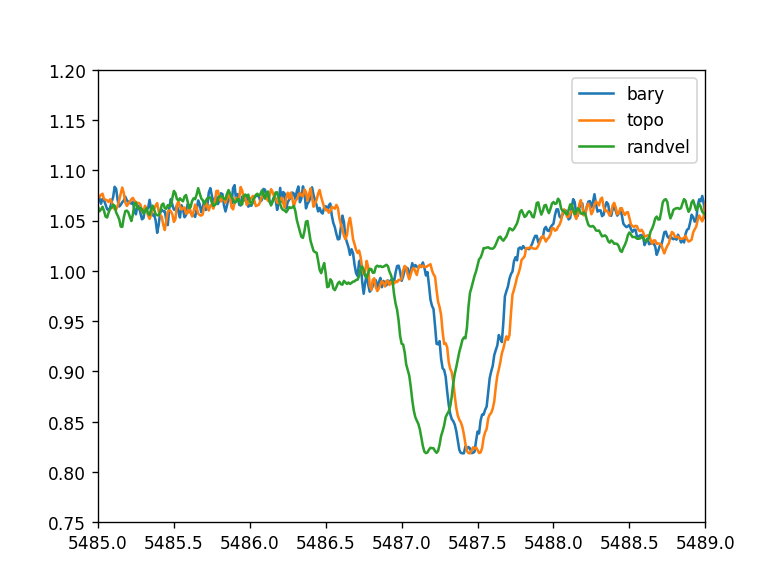

(0.75, 1.2)

In [6]:
plt.figure()
plt.plot(WAVE, flux, label='bary')
plt.plot(WAVE, f_topo, label='topo')
plt.plot(WAVE, f_randvel, label='randvel')
plt.legend()
plt.xlim(5485,5489)
plt.ylim(0.75,1.2)
    

Plot the covariance matrix before and after whitening -- Figure 4

<IPython.core.display.Javascript object>


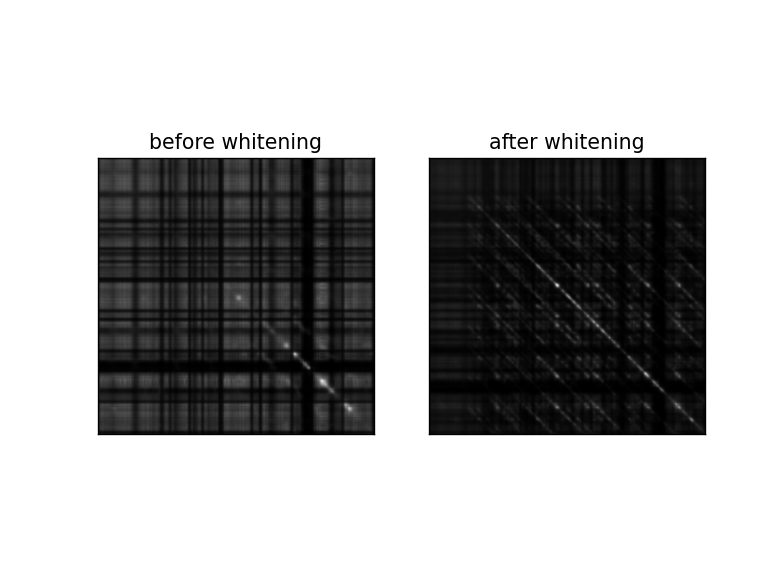

In [7]:
w = WAVE
ROI = (w>6275)&(w<6282)
cov1 = np.cov(data_topo[:,ROI].T)
cov2 = np.cov(data_randvel[:,ROI].T)

plt.figure()

ax1 = plt.subplot(121)
plt.imshow(cov1**4, cmap='gray')
plt.xticks([]);plt.yticks([])
plt.title('before whitening')

ax2 = plt.subplot(122)
plt.imshow(cov2**4, cmap='gray')
plt.xticks([]);plt.yticks([])
plt.title('after whitening')

plt.savefig(f'./covariance.png', bbox_inches='tight')
plt.show()

### Telluric Rejection

In [1]:
import sys
sys.path.append('./models')
import models

In [6]:
ids_to_test = ['ADP.2014-09-16T11:05:10.627', # various items from the unique set
               'ADP.2014-09-16T11:03:31.413',
               'ADP.2014-09-16T11:03:31.673',
               'ADP.2014-10-01T10:22:48.507'
]

In [29]:
#--- Setup the network
pretrained_model = 'models/pretrained.pth.tar'
device = 'cpu'
network_data = torch.load(pretrained_model)

model = models.ae1d().to(device)
model.load_state_dict(network_data['state_dict'],strict=True);

In [26]:
orig_spectra = []
reconsts = []
for spec_ID in ids_to_test:
    #-- Load the original spectrum
    w, data = load_harps_spectrum(specID=spec_ID,data_path='~/remote_epyc_data3/HARPS/fits/')
    
    #-- Apply the pre-processing steps (trimming, uniform wavelength grids) 
    _, flux = spec_info.preprocess(w, data)
    orig_spectra.append(flux)
    
    #-- Pass it through the network
    reconst = model.forward(torch.from_numpy(flux).unsqueeze(0).unsqueeze(0).to(device))
    reconsts.append(reconst.detach().numpy().squeeze())

Reproduce figure 5

In [24]:
# Color-blind palette
CB = {
    'blue':   '#377eb8',
    'orange': '#ff7f00',
    'green':  '#4daf4a',
    'pink':   '#f781bf',
    'brown':  '#a65628',
    'purple': '#984ea3',
    'gray':   '#999999',
    'red':    '#e41a1c',
    'yellow': '#dede00',
}

<IPython.core.display.Javascript object>


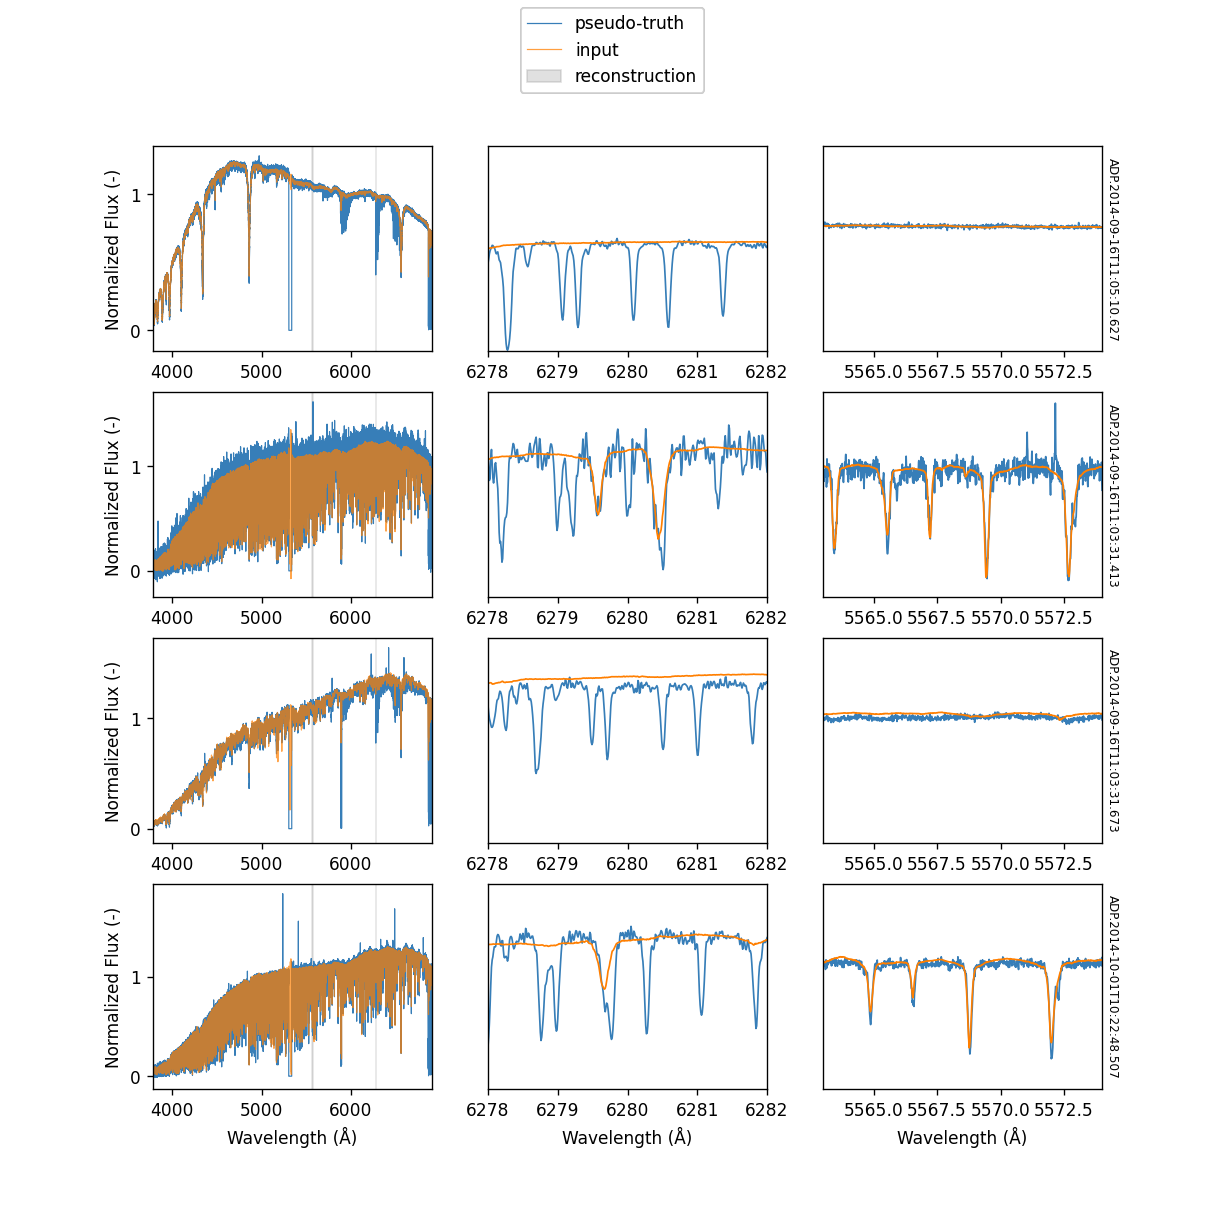

Text(0.5, 0, 'Wavelength (Å)')

In [28]:
ROI1 = [6278,6282]
ROI2 = [5563,5574]

last_ax = None
wave_space = 'bary'
f = plt.figure(figsize=(10,10))
n = len(orig_spectra)
for i in range(n):
    w = WAVE

    ax1 = plt.subplot(n,3,i*3+1)
    #ax1.plot(w, G_s[i], color=CB["green"], linewidth=.7)
    ax1.plot(w,orig_spectra[i].squeeze(),color=CB["blue"],linewidth=.7)
    ax1.plot(w,reconsts[i],color=CB["orange"],linewidth=.7, alpha=0.7)
    # plot shades for ROIs
    ax1.axvspan(ROI1[0], ROI1[1], alpha=0.2, color='grey')
    ax1.axvspan(ROI2[0], ROI2[1], alpha=0.2, color='grey')
    ax1.set_xlim([spec_info.desiredMinW,spec_info.desiredMaxW]) #whole spec
    ax1.set_yticks([0,1])
    ax1.set_ylabel(f'Normalized Flux (-)')

    ax2 = plt.subplot(n,3,i*3+2)
    #ax2.plot(w, G_s[i], color=CB["green"], linewidth=1)
    ax2.plot(w,orig_spectra[i].squeeze(),color=CB["blue"],linewidth=1)
    ax2.plot(w,reconsts[i],color=CB["orange"],linewidth=1)
    ax2.set_xlim(ROI1) # telluric region
    ax2.set_ylim([0.4,1.5])
    ax2.set_yticks([])

    ax3 = plt.subplot(n,3,i*3+3)
    #ax3.plot(w, G_s[i], color=CB["green"], linewidth=1)
    ax3.plot(w,orig_spectra[i].squeeze(),color=CB["blue"],linewidth=1)
    ax3.plot(w,reconsts[i],color=CB["orange"],linewidth=1)
    ax3.set_xlim(ROI2) #normal region 2
    ax3.set_ylim([0.2,1.6])
    ax3.set_yticks([])
    ax3.yaxis.set_label_position("right")
    ax3.set_ylabel(f'{ids_to_test[i]}\n\n\n\n\n\n', rotation=-90, fontsize=7, labelpad=10)

    plt.figlegend(['pseudo-truth','input','reconstruction'],loc='upper center')

    last_ax1 = ax1
    last_ax2 = ax2
    last_ax3 = ax3

last_ax1.set_xlabel('Wavelength (Å)')
last_ax2.set_xlabel('Wavelength (Å)')
last_ax3.set_xlabel('Wavelength (Å)')